In [7]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

path = os.getcwd()
if path.split('/')[-1] == 'notebooks':
    os.chdir('..')
%matplotlib inline

In [8]:
from src.engine import Engine
from src.utils.util import *
from src.core.criterions import *

# Load a model

In [9]:
config_path = 'configs/mln_resnet18_mnist.yml'
save_dir = '/home/yo0n/바탕화면/RIL/ucam/notebook_test'
logger = load_log(save_dir)
checkpoint_path = '/home/yo0n/바탕화면/RIL/ucam/ckpt_mnist/checkpoint_best.pth'

In [10]:
engine = Engine(config_path, logger, save_dir,device='cuda')
engine.model_config['checkpoint_path'] = checkpoint_path
engine.define()


[2021-08-01 13:57:24,628 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] GPU is available.
[2021-08-01 13:57:24,669 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] SGD opimizer is built.
[2021-08-01 13:57:24,670 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] CUSTOM scheduler is built.
[2021-08-01 13:57:24,670 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Criterion is built.
[2021-08-01 13:57:24,671 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loss meter is built.
[2021-08-01 13:57:24,671 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Checkpointer is built.
[2021-08-01 13:57:24,672 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loading checkpoint from /home/yo0n/바탕화면/RIL/ucam/ckpt_mnist/checkpoint_best.pth
[2021-08-01 13:57:24,682 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Localizer is built.
[2021-08-01 13:57:24,683 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Evaluators are built.


Build a dataloader
Build a model


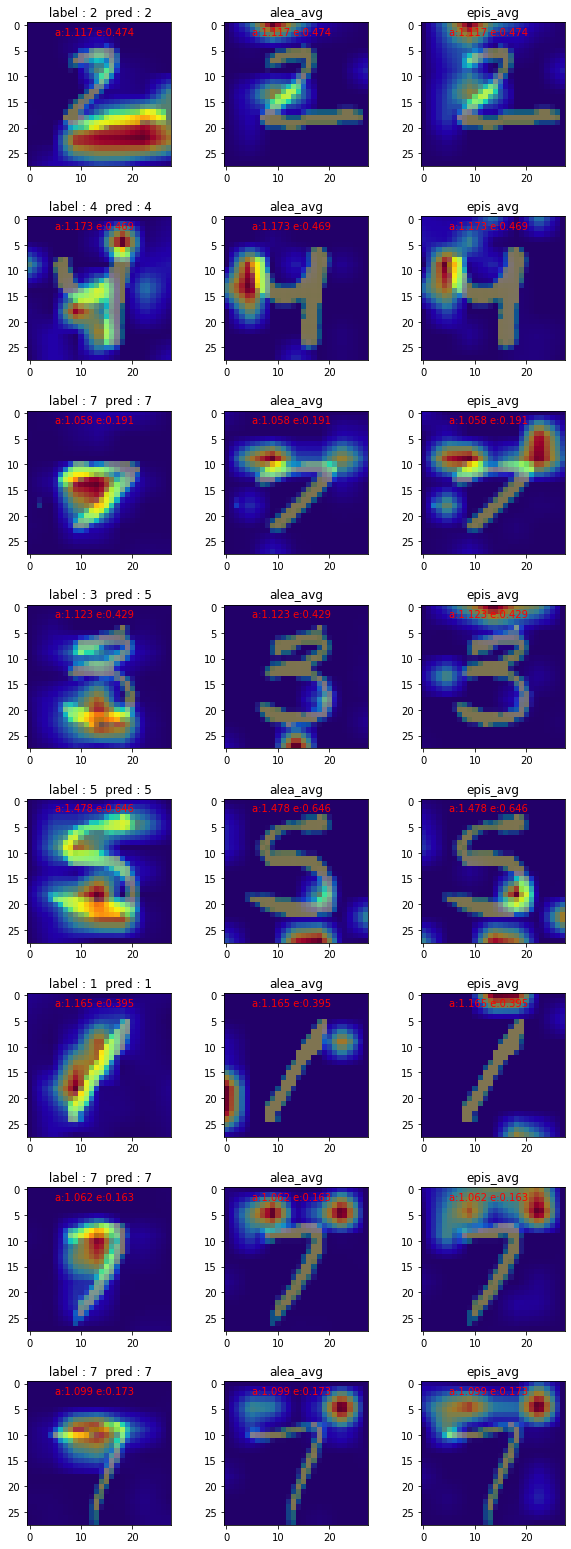

In [11]:
import random 

loss_types = ['mace_avg','alea_avg','epis_avg']

img,label,_ = iter(engine.dataloaders['train']).next()
bs = img.shape[0]
with torch.no_grad():
    output_dict = engine.model(img.cuda())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel']
ind_sel = torch.topk(mu_sel,3,dim=-1)[-1]

#print(mu_sel[1], label[1])

plt.figure(figsize=(10,80))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
l = [i for i in range(bs)]
random.shuffle(l)

for j,ind in enumerate(l[:8]):
    for i,loss_type in enumerate(loss_types):
        
        engine.model.eval()
        engine.localizer.register_hooks()
        engine.localizer.model_ext.loss_type= loss_type
        
        pred_label = torch.tensor([ind_sel[ind,0]]).long()
        
        cams = engine.localizer.localize(img[ind].unsqueeze(0).to('cuda').float(), pred_label.to('cuda'))
        cams = cams.cpu().detach().squeeze().numpy()
        #print(cams)
        
        epis = unct_out['epis'][j]
        alea = unct_out['alea'][j]
        
        plt.subplot(8*3,3,3*j+i+1)
        if(i==0):
            plt.title(" label : " + str(label[ind].numpy()) + "  pred : " + str(ind_sel[ind,0].cpu().numpy()))
        else:
            plt.title(loss_type)
        plt.imshow(img[ind].squeeze() + 0.5)
        plt.imshow(cams, alpha=0.5, cmap='jet')
        plt.text(5, 2, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10, color='red')


<Figure size 1440x11520 with 0 Axes>

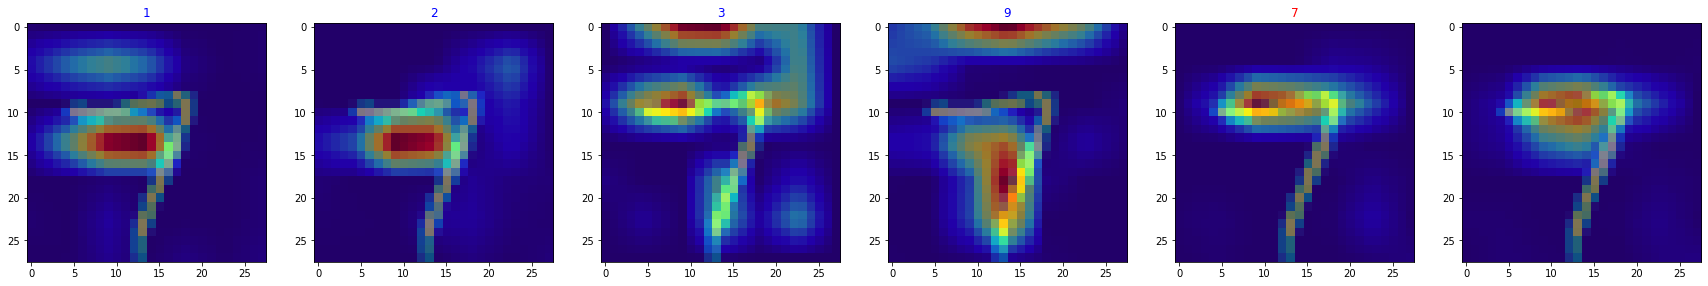

In [13]:
plt.figure(figsize=(20,160))

randInd = random.randint(0,64)

largest_pi_ind = torch.argmax(pi[randInd])
mixture_k = engine.model.mol.fc_pi.weight.size(0)

plt.figure(figsize=(30,100))
for k in range(mixture_k):
    engine.localizer.register_hooks()
    engine.localizer.model_ext.loss_type= 'mace_avg'
    mixture_pred_name = str(torch.argmax(mu[randInd,k]).cpu().numpy())
    
    cams = engine.localizer.localize(img.to('cuda').float(), label.to('cuda'), mixture=k)
    cams = cams.cpu().detach().squeeze().numpy()
    
    plt.subplot(mixture_k,mixture_k+1,k+1)
    if(largest_pi_ind==k):
        plt.title(mixture_pred_name,color='red')
    else:
        plt.title(mixture_pred_name,color='blue')
    plt.imshow(img[randInd].squeeze())
    plt.imshow(cams[randInd], alpha=0.5, cmap='jet')

engine.localizer.remove_hooks()

engine.localizer.register_hooks()
cams = engine.localizer.localize(img.to('cuda').float(), label.to('cuda'))
engine.localizer.remove_hooks()

plt.subplot(mixture_k, mixture_k+1, k+2)
plt.imshow(img[randInd].detach().squeeze().cpu())
plt.imshow(cams[randInd].detach().cpu().squeeze(), alpha=0.5, cmap='jet')

## Ambiguous MNIST

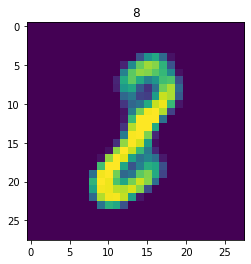

In [14]:
from src.core.datasets import AmbiguousMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

transform  = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (1.0,))
                    ])
amnist_validset = AmbiguousMNIST(root = "./data", train=False)
amnist_valid_loader = DataLoader(amnist_validset, batch_size=128,shuffle=True, num_workers=0)

rndInd = random.randint(0,len(amnist_validset))
plt.title(str(amnist_validset[rndInd][1].numpy()))
plt.imshow(amnist_validset[rndInd][0][0])

In [15]:
alea_mnist = list()
epis_mnist = list()
mnist_labels = list()
mnist_pi_ind = list()
mnist_pred = list()
mnist_correct = list()
alea_amnist = list()
epis_amnist = list()
amnist_correct = list()

for img,target,_ in engine.dataloaders['test']:
    bs = img.shape[0]
    with torch.no_grad():
        output_dict = engine.model(img.cuda())
    pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
    unct_out = mln_uncertainties(pi, mu, sigma)
    sel_out = mln_gather(output_dict)
    mu_sel = sel_out['mu_sel']
    mnist_correct += list((torch.argmax(mu_sel,dim=1).cpu()==target.cpu()).cpu().numpy())
    alea_mnist += list(unct_out['alea'].cpu().numpy())
    epis_mnist += list(unct_out['epis'].cpu().numpy())
    mnist_pi_ind += list(torch.argmax(pi,dim=1).cpu().numpy())
    mnist_labels += list(target.cpu().numpy())
    mnist_pred += list(torch.argmax(mu_sel,dim=1).cpu().numpy())
    
for img,target,_ in amnist_valid_loader:
    bs = img.shape[0]
    with torch.no_grad():
        output_dict = engine.model(img.cuda())
    pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
    unct_out = mln_uncertainties(pi, mu, sigma)
    sel_out = mln_gather(output_dict)
    mu_sel = sel_out['mu_sel']
    amnist_correct += list((torch.argmax(mu_sel,dim=1).cpu()==target.cpu()).cpu().numpy())
    alea_amnist += list(unct_out['alea'].cpu().numpy())
    epis_amnist += list(unct_out['epis'].cpu().numpy())

<AxesSubplot:>

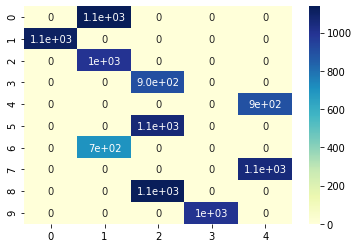

In [16]:
import seaborn as sns

confusion_matrix = np.zeros((10,5))
for i in range(len(mnist_labels)):
    confusion_matrix[mnist_pred[i],mnist_pi_ind[i]] += 1
    
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

<AxesSubplot:>

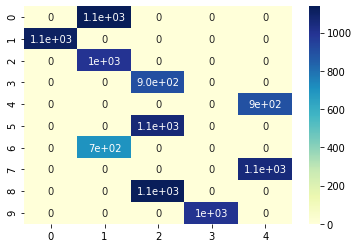

In [17]:
import seaborn as sns

confusion_matrix = np.zeros((10,5))
for i in range(len(mnist_labels)):
    confusion_matrix[mnist_pred[i],mnist_pi_ind[i]] += 1
    
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

<AxesSubplot:>

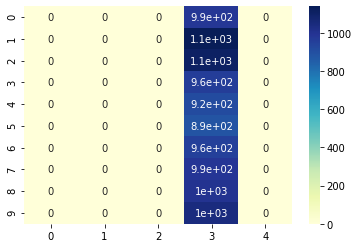

In [14]:
import seaborn as sns

confusion_matrix = np.zeros((10,5))
for i in range(len(mnist_labels)):
    confusion_matrix[mnist_pred[i],mnist_pi_ind[i]] += 1
    
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")

(array([6.04220618e+01, 1.11730733e+01, 5.50189215e+00, 2.99077215e+00,
        1.43895641e+00, 1.12859326e+00, 4.51437305e-01, 4.23222473e-01,
        3.24470563e-01, 1.69288989e-01, 1.83398256e-01, 5.64296631e-02,
        1.26966742e-01, 0.00000000e+00, 5.64296631e-02, 4.23222473e-02,
        1.41074158e-02, 4.23222473e-02, 1.41074158e-02, 8.46444947e-02]),
 array([1.0000501, 1.0118642, 1.0236783, 1.0354924, 1.0473065, 1.0591207,
        1.0709348, 1.0827489, 1.094563 , 1.1063771, 1.1181912, 1.1300052,
        1.1418194, 1.1536335, 1.1654476, 1.1772617, 1.1890758, 1.20089  ,
        1.2127041, 1.2245182, 1.2363323], dtype=float32),
 <BarContainer object of 20 artists>)

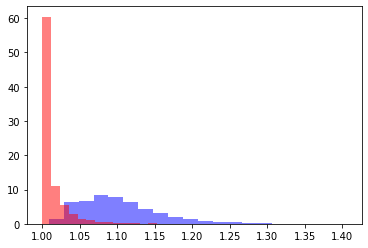

In [17]:
plt.hist(alea_mnist,color='blue',alpha=0.5, bins=20, density=True)
plt.hist(alea_amnist,color='red',alpha=0.5, bins=20, density=True)

(array([0.89982765, 0.53255117, 0.46827761, 0.55091495, 0.70700766,
        0.82178129, 1.11560254, 1.34055943, 1.63438201, 1.57010727,
        1.81342799, 2.29547847, 2.74080354, 3.31925914, 4.43486805,
        1.64356393, 0.84932634, 0.54632432, 0.18822908, 0.07345537]),
 array([0.01004727, 0.04635051, 0.08265375, 0.11895701, 0.15526025,
        0.19156349, 0.22786674, 0.26417   , 0.30047324, 0.33677647,
        0.37307972, 0.40938297, 0.44568622, 0.48198944, 0.5182927 ,
        0.55459595, 0.59089917, 0.62720245, 0.6635057 , 0.69980896,
        0.7361122 ], dtype=float32),
 <BarContainer object of 20 artists>)

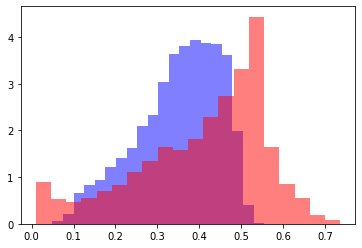

In [19]:
plt.hist(epis_mnist,color='blue',alpha=0.5, bins=20, density=True)
plt.hist(epis_amnist,color='red',alpha=0.5, bins=20, density=True)

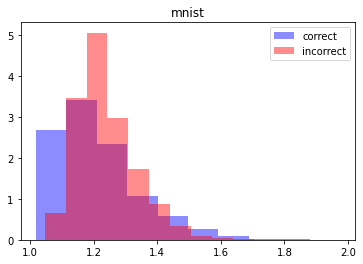

In [20]:
plt.title("mnist")
plt.hist(np.power(np.array(alea_mnist)[np.array(mnist_correct)==1],2),color='blue', alpha=0.45, density=True, label='correct')
plt.hist(np.power(np.array(alea_mnist)[np.array(mnist_correct)==0],2),color='red', alpha=0.45, density=True, label='incorrect')
plt.legend()

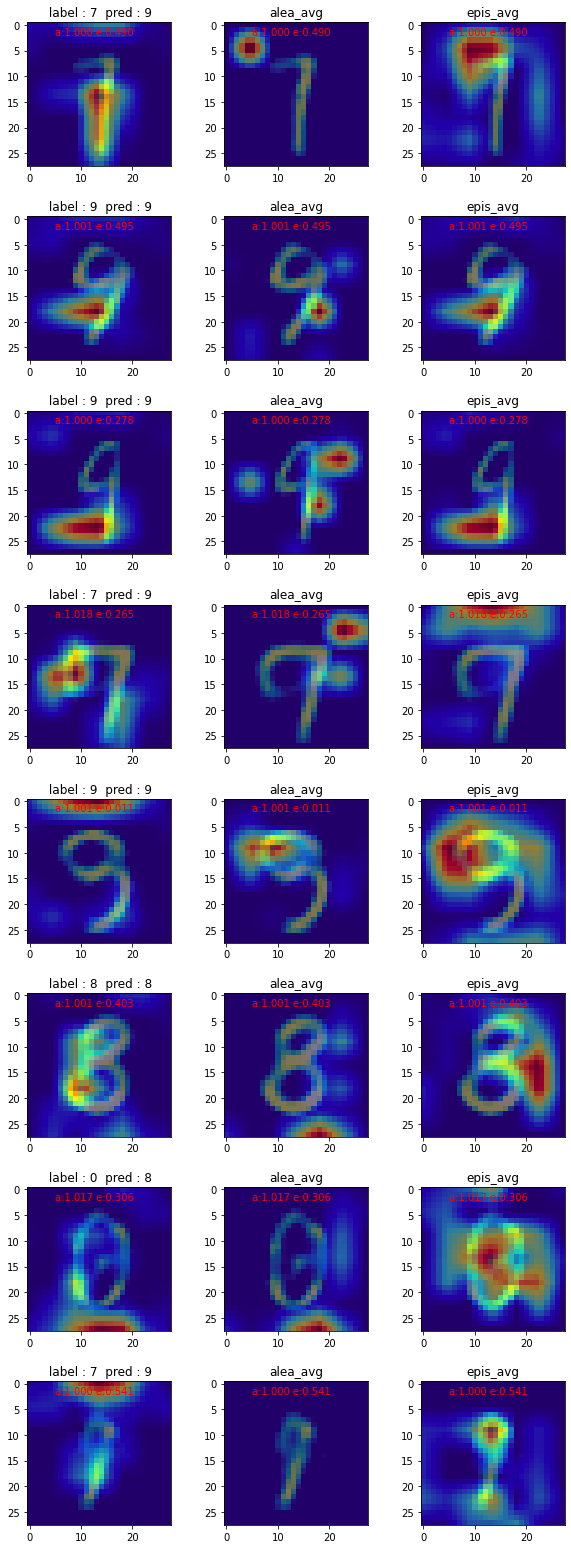

In [21]:
import random 

loss_types = ['mace_avg','alea_avg','epis_avg']

img,label,_ = iter(amnist_valid_loader).next()
bs = img.shape[0]
with torch.no_grad():
    output_dict = engine.model(img.cuda())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel']
ind_sel = torch.topk(mu_sel,3,dim=-1)[-1]

#print(mu_sel[1], label[1])

plt.figure(figsize=(10,80))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
l = [i for i in range(bs)]
random.shuffle(l)

for j,ind in enumerate(l[:8]):
    for i,loss_type in enumerate(loss_types):
        
        engine.model.eval()
        engine.localizer.register_hooks()
        engine.localizer.model_ext.loss_type= loss_type
        
        pred_label = torch.tensor([ind_sel[ind,0]]).long()
        
        cams = engine.localizer.localize(img[ind].unsqueeze(0).to('cuda').float(), pred_label.to('cuda'))
        cams = cams.cpu().detach().squeeze().numpy()
        #print(cams)
        
        epis = unct_out['epis'][j]
        alea = unct_out['alea'][j]
        
        plt.subplot(8*3,3,3*j+i+1)
        if(i==0):
            plt.title(" label : " + str(label[ind].numpy()) + "  pred : " + str(ind_sel[ind,0].cpu().numpy()))
        else:
            plt.title(loss_type)
        plt.imshow(img[ind].squeeze() + 0.5)
        plt.imshow(cams, alpha=0.5, cmap='jet')
        plt.text(5, 2, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10, color='red')

# OOD (SVHN)

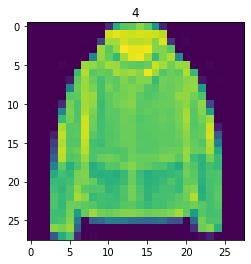

In [22]:
import torchvision

fmnist_valid = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
fmnist_valid_loader = DataLoader(fmnist_valid, batch_size=128,shuffle=True, num_workers=0)

rndInd = random.randint(0,len(fmnist_valid))
plt.title(str(fmnist_valid[rndInd][1]))
plt.imshow(fmnist_valid[rndInd][0].squeeze() + 0.5)

In [23]:

alea_fmnist = list()
epis_fmnist = list()
fmnist_correct = list()


for img,target in fmnist_valid_loader:
    bs = img.shape[0]
    with torch.no_grad():
        output_dict = engine.model(img.cuda())
    pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
    unct_out = mln_uncertainties(pi, mu, sigma)
    sel_out = mln_gather(output_dict)
    mu_sel = sel_out['mu_sel']
    fmnist_correct += list((torch.argmax(mu_sel,dim=1).cpu()==target.cpu()).cpu().numpy())
    alea_fmnist += list(unct_out['alea'].cpu().numpy())
    epis_fmnist += list(unct_out['epis'].cpu().numpy())

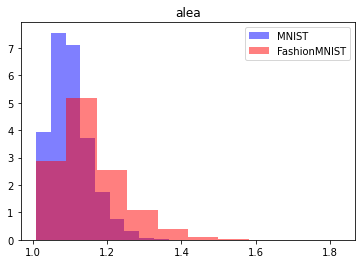

In [24]:
plt.title("alea")
plt.hist(alea_mnist,color='blue',alpha=0.5, density=True, label='MNIST')
plt.hist(alea_fmnist,color='red',alpha=0.5, density=True, label='FashionMNIST')
plt.legend()

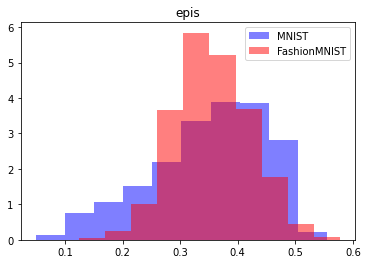

In [25]:
plt.title("epis")
plt.hist(epis_mnist,color='blue',alpha=0.5, density=True, label='MNIST')
plt.hist(epis_fmnist,color='red',alpha=0.5, density=True, label='FashionMNIST')
plt.legend()

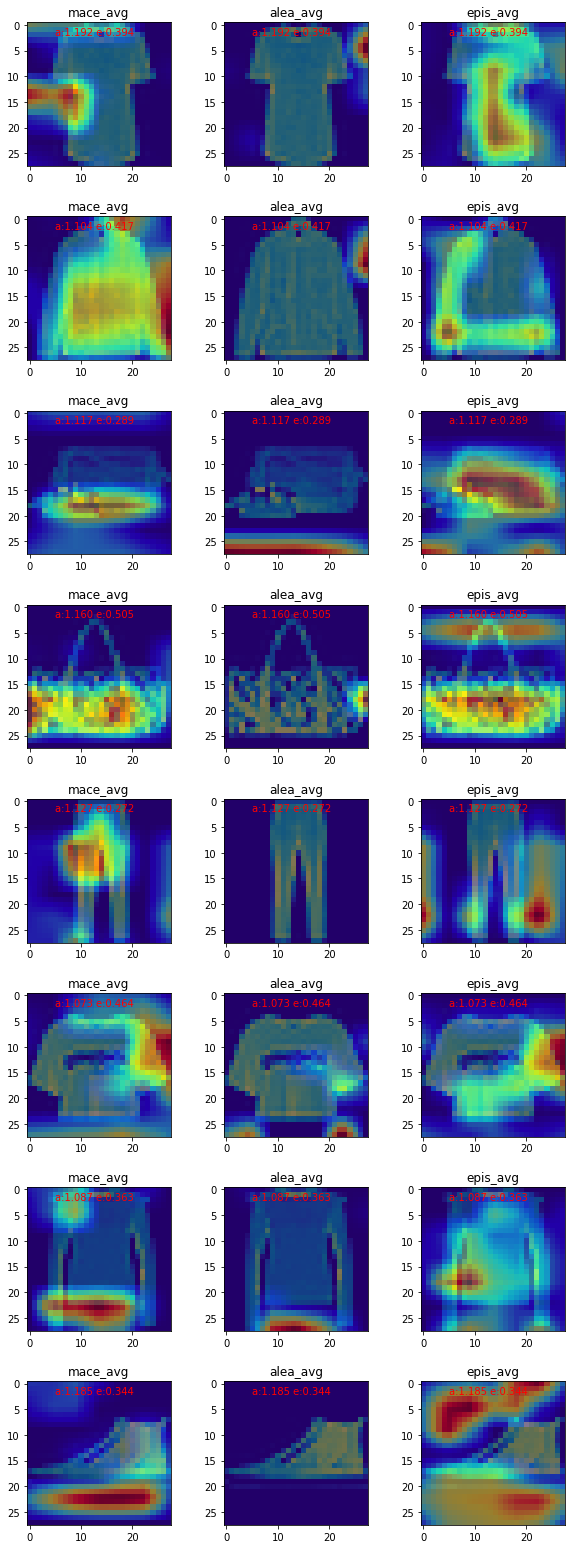

In [26]:
import random 

loss_types = ['mace_avg','alea_avg','epis_avg']

img,label = iter(fmnist_valid_loader).next()
bs = img.shape[0]
with torch.no_grad():
    output_dict = engine.model(img.cuda())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel']
ind_sel = torch.topk(mu_sel,3,dim=-1)[-1]

#print(mu_sel[1], label[1])

plt.figure(figsize=(10,80))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
l = [i for i in range(bs)]
random.shuffle(l)

for j,ind in enumerate(l[:8]):
    for i,loss_type in enumerate(loss_types):
        
        engine.model.eval()
        engine.localizer.register_hooks()
        engine.localizer.model_ext.loss_type= loss_type
        
        pred_label = torch.tensor([ind_sel[ind,0]]).long()
        
        cams = engine.localizer.localize(img[ind].unsqueeze(0).to('cuda').float(), pred_label.to('cuda'))
        cams = cams.cpu().detach().squeeze().numpy()
        #print(cams)
        
        epis = unct_out['epis'][j]
        alea = unct_out['alea'][j]
        
        plt.subplot(8*3,3,3*j+i+1)
        plt.title(loss_type)
        plt.imshow(img[ind].squeeze() + 0.5)
        plt.imshow(cams, alpha=0.5, cmap='jet')
        plt.text(5, 2, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10, color='red')